In [1]:
import argparse
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import sys

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as tf

from mypath import Path
from dataloaders import aicup
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.loss import SegmentationLosses
from utils.calculate_weights import calculate_weigths_labels
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator

import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd


In [2]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

In [3]:
class tmp_obj():
    def __init__(self):
        self.task = 'segmentation'
        self.crop_size=513

In [4]:
args = tmp_obj()

In [5]:
train_set = aicup.AICUPDataset(args, split='Train_Dev')
test_set = aicup.AICUPDataset(args, split='test_public')
num_class = test_set.NUM_CLASSES if args.task=='segmentation' else 1
train_loader = DataLoader(train_set, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=4)

Number of images in Train_Dev: 44
Number of images in test_public: 47


In [6]:
evaluator = Evaluator(num_class)

In [7]:
model = DeepLab(num_classes=num_class,
                backbone='resnet',
                output_stride=16,
                sync_bn=None,
                freeze_bn=False)

In [8]:
model = nn.DataParallel(model).to(DEVICE)

In [9]:
checkpoint = torch.load('./run/aicup/deeplab-resnet/experiment_0/checkpoint.pth.tar')
checkpoint['best_pred']

0.9979909021789888

In [10]:
model.module.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [11]:
model.eval()
evaluator.reset()
for i, sample in enumerate(train_loader):
    image, target = sample['image'].to(DEVICE), sample['label'].to(DEVICE)
    output = model(image)
    pred = output.data.cpu().numpy()
    target = target.cpu().numpy()
    pred = np.argmax(pred, axis=1)
    evaluator.add_batch(target, pred)
evaluator.Pixel_Accuracy_Class()

0.5015128212521051

In [12]:
np.set_printoptions(suppress=True)
print(evaluator.confusion_matrix)

[[11526952.    49753.]
 [    2711.       20.]]


In [13]:
output = model(torch.unsqueeze(image[0], 0))
pred = output.data.cpu().numpy()
target = target[0]
pred = np.argmax(pred, axis=1)

In [14]:
evaluator.add_batch(target, pred[0])

In [15]:
np.set_printoptions(suppress=True)
print(evaluator.confusion_matrix)

[[11789653.    50188.]
 [    2744.       20.]]


In [16]:
np.transpose(np.nonzero(pred[0]))

array([[ 52, 336],
       [143, 504],
       [143, 505],
       [143, 506],
       [144, 503],
       [144, 504],
       [144, 505],
       [144, 506],
       [144, 507],
       [144, 508],
       [145, 503],
       [145, 504],
       [145, 505],
       [145, 506],
       [145, 507],
       [146, 503],
       [146, 504],
       [146, 505],
       [146, 506],
       [147, 452],
       [147, 503],
       [147, 504],
       [147, 505],
       [148, 451],
       [148, 452],
       [148, 453],
       [148, 503],
       [148, 504],
       [148, 505],
       [149, 451],
       [149, 452],
       [149, 453],
       [149, 504],
       [150, 451],
       [150, 452],
       [150, 453],
       [150, 504],
       [151, 452],
       [152, 452],
       [187, 304],
       [188, 304],
       [188, 305],
       [189, 303],
       [189, 304],
       [189, 305],
       [190, 171],
       [190, 172],
       [190, 303],
       [190, 304],
       [190, 305],
       [190, 306],
       [191, 170],
       [191,

In [17]:
np.transpose(np.nonzero(target[0]))

array([], shape=(0, 1), dtype=int64)

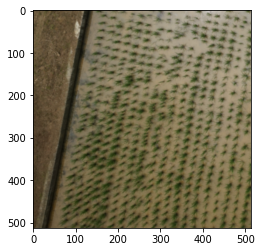

In [18]:
mean=torch.Tensor([0.485, 0.456, 0.406])
std=torch.Tensor([0.229, 0.224, 0.225])

transform = tf.Compose([
    tf.Normalize((-mean/std).tolist(), (1./std).tolist()),
    tf.ToPILImage(),
])

img = transform(image[0].cpu())
img = img.convert('RGB')
plt.imshow(img)

In [19]:
# List all images
_img_names = sorted(os.listdir('../data/Train_Dev/training/'))
for i, _img in enumerate(_img_names):
    _img_names[i] = _img[:-4]

In [20]:
_img_names

['DSC080454',
 'DSC080552',
 'DSC080694',
 'DSC080814',
 'DSC080993',
 'DSC081022',
 'DSC081093',
 'DSC081101',
 'DSC081104',
 'DSC081272',
 'DSC081541',
 'DSC081681',
 'DSC081682',
 'DSC081693',
 'DSC081721',
 'DSC081724',
 'DSC081871',
 'DSC082112',
 'DSC082123',
 'DSC082144',
 'DSC082151',
 'DSC082451',
 'DSC082761',
 'DSC082764',
 'DSC082791',
 'IMG_170406_035932_0022_RGB4',
 'IMG_170406_035933_0023_RGB3',
 'IMG_170406_035939_0028_RGB3',
 'IMG_170406_040009_0053_RGB1',
 'IMG_170406_040033_0073_RGB2',
 'IMG_170406_040105_0099_RGB4',
 'IMG_170406_040108_0102_RGB3',
 'IMG_170406_040108_0102_RGB4',
 'IMG_170406_040156_0142_RGB1',
 'IMG_170406_040202_0147_RGB3',
 'IMG_170406_040202_0147_RGB4',
 'IMG_170406_040308_0202_RGB1',
 'IMG_170406_040351_0238_RGB4',
 'IMG_170406_040353_0239_RGB2',
 'IMG_170406_040354_0240_RGB4',
 'IMG_170406_040355_0241_RGB4',
 'IMG_170406_040356_0242_RGB2',
 'IMG_170406_040408_0252_RGB2',
 'IMG_170406_040409_0253_RGB3']

In [21]:
# Pick 1 image for inference
_img_name = _img_names[3]

In [22]:
# Parameters for visualizing dots
_range = 10
_dis=20

In [23]:
image = Image.open('../data/Train_Dev/training/'+_img_name+'.JPG').convert('RGB')
_points = pd.read_csv('../data/Train_Dev/train_labels/'+_img_name+'.csv', header=None).to_numpy()

# image = img
# _points = np.transpose(np.nonzero(target))

In [24]:
# print(np.array(sorted(_points, key=lambda a:a[0])))
label = np.zeros(image.size)
visualized_label = np.zeros(image.size)
for (x, y) in _points:
    label[x, y] = 1.
    for i in range(-_range, _range):
           for j in range(-_range, _range):
                if x+i >= label.shape[0] or y+j >= label.shape[1] or x+i<0 or y+j<0 \
                    or (i**2+j**2)**0.5 > _dis:
                    continue
                visualized_label[x+i, y+j] = 1.
# print(np.transpose(np.nonzero(label)))
#label = np.transpose(label)
visualized_label = np.transpose(visualized_label)

label = Image.fromarray(np.uint8(label*255))
visualized_label = Image.fromarray(np.uint8(visualized_label*255))
w, h = image.size
if w > h:
    oh = args.crop_size
    ow = int(1.0 * w * oh / h)
else:
    ow = args.crop_size
    oh = int(1.0 * h * ow / w)

image = image.resize((ow, oh), Image.BILINEAR)
label = label.resize((ow, oh), Image.NEAREST)
visualized_label = visualized_label.resize((ow, oh), Image.NEAREST)

w, h = image.size
x1, y1 = int(round((w - args.crop_size) / 2.)), int(round((h - args.crop_size) / 2.))
x2, y2 = x1+args.crop_size, y1+args.crop_size
image = image.crop((x1, y1, x2, y2))
label = label.crop((x1, y1, x2, y2))
visualized_label = visualized_label.crop((x1, y1, x2, y2))

image = np.array(image)

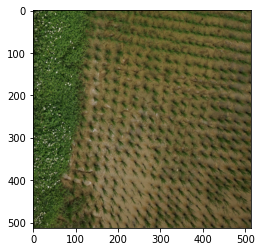

In [25]:
plt.imshow(image)

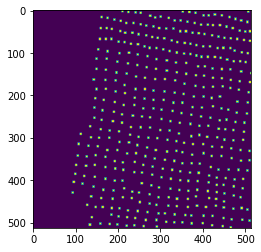

In [26]:
plt.imshow(visualized_label)

In [27]:
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

image = image.astype(np.float32)
image /= 255.0
image -= mean
image /= std

In [28]:
tensor_image = torch.unsqueeze(tf.ToTensor()(image).to(DEVICE), 0)
tensor_label = torch.unsqueeze(tf.ToTensor()(label).to(DEVICE), 0)
tensor_label.shape

torch.Size([1, 1, 513, 513])

In [29]:
model.eval()
output = model(tensor_image)
pred = output.data.cpu().numpy()
pred = np.argmax(pred, axis=1)

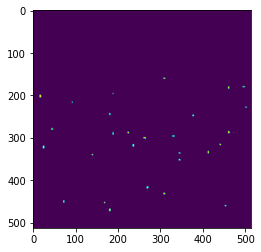

In [30]:
plt.figure()
plt.imshow(pred[0])
plt.show()

In [31]:
np.transpose(np.nonzero(pred[0]))

array([[159, 307],
       [159, 308],
       [159, 309],
       [160, 306],
       [160, 307],
       [160, 308],
       [160, 309],
       [160, 310],
       [160, 311],
       [161, 307],
       [161, 308],
       [161, 309],
       [161, 310],
       [179, 460],
       [179, 495],
       [179, 496],
       [179, 497],
       [180, 459],
       [180, 460],
       [180, 461],
       [180, 492],
       [180, 493],
       [180, 494],
       [180, 495],
       [180, 496],
       [180, 497],
       [180, 498],
       [181, 459],
       [181, 460],
       [181, 461],
       [181, 495],
       [181, 496],
       [181, 497],
       [182, 459],
       [182, 460],
       [182, 461],
       [183, 459],
       [183, 460],
       [183, 461],
       [184, 459],
       [184, 460],
       [184, 461],
       [185, 460],
       [195, 188],
       [196, 187],
       [196, 188],
       [196, 189],
       [197, 188],
       [199,  16],
       [199,  17],
       [200,  15],
       [200,  16],
       [200,

In [32]:
tensor_label.cpu().numpy()

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)

In [33]:
target = np.squeeze(tensor_label.cpu().numpy())
np.transpose(np.nonzero(target))

array([[160, 309],
       [180, 495],
       [182, 460],
       [196, 188],
       [202,  17],
       [216,  92],
       [228, 501],
       [245, 181],
       [247, 377],
       [279,  45],
       [287, 223],
       [287, 461],
       [290, 188],
       [296, 330],
       [301, 263],
       [316, 440],
       [318, 235],
       [322,  25],
       [334, 412],
       [336, 345],
       [340, 139],
       [352, 345],
       [417, 269],
       [431, 309],
       [450,  72],
       [453, 168],
       [460, 453],
       [470, 181]])

In [34]:
evaluator.reset()

In [35]:
evaluator.add_batch(target, pred[0])

In [36]:
evaluator.Pixel_Accuracy_Class()

0.9992475516928188

In [37]:
np.set_printoptions(suppress=True)
print(evaluator.confusion_matrix)

[[262745.    396.]
 [     0.     28.]]
